In [111]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [104]:
# Tạo ra tọa độ ngẫu nhiên cho mỗi thành phố
def generate_city_coordinates(num_cities):
    city_coords = []
    for _ in range(num_cities):
        x = random.uniform(0, 100)  # Tọa độ x ngẫu nhiên trong khoảng từ 0 đến 100
        y = random.uniform(0, 100)  # Tọa độ y ngẫu nhiên trong khoảng từ 0 đến 100
        city_coords.append((x, y))
    return city_coords

In [101]:
# Tính toán khoảng cách giữa các thành phố
def calculate_distance_matrix(city_coords):
    num_cities = len(city_coords)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            # Tính khoảng cách Euclid giữa hai thành phố
            distance = np.sqrt((city_coords[i][0] - city_coords[j][0])**2 + (city_coords[i][1] - city_coords[j][1])**2)
            # Gán khoảng cách cho cả hai hướng vì ma trận khoảng cách là ma trận đối xứng
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

In [41]:
# Khởi tạo ma trận feromon
def init_pheromone_matrix(num_cities, initial_pheromone):
    return np.ones((num_cities, num_cities)) * initial_pheromone

In [69]:
# Lựa chọn thành phố tiếp theo cho một con kiến
def select_next_city(current_city, pheromone_matrix, distance_matrix, alpha, beta, remaining_cities):
    pheromone = pheromone_matrix[current_city]
    distance = distance_matrix[current_city]
    probabilities = np.power(pheromone, alpha) * np.power(1.0 / distance, beta)
    probabilities[current_city] = 0  # Loại bỏ việc chọn lại thành phố hiện tại

    # Lọc ra chỉ các thành phố còn lại để chọn
    remaining_probabilities = probabilities[list(remaining_cities)]
    remaining_probabilities = remaining_probabilities / np.sum(remaining_probabilities)
    next_city = np.random.choice(list(remaining_cities), p=remaining_probabilities)
    return next_city

In [64]:
# Cập nhật ma trận feromon sau mỗi lượt đi
def update_pheromone(pheromone_matrix, ants, distance_matrix, decay_factor, Q):
    pheromone_matrix *= (1 - decay_factor)  # Bay hơi feromon
    for ant in ants:
        distance = 0
        for i in range(len(ant) - 1):
            distance += distance_matrix[ant[i]][ant[i+1]]
        distance += distance_matrix[ant[-1]][ant[0]]  # Quay trở lại thành phố ban đầu
        for i in range(len(ant) - 1):
            pheromone_matrix[ant[i]][ant[i+1]] += Q / distance
            pheromone_matrix[ant[i+1]][ant[i]] += Q / distance
        pheromone_matrix[ant[-1]][ant[0]] += Q / distance
        pheromone_matrix[ant[0]][ant[-1]] += Q / distance

In [54]:
def update_pheromone(pheromone_matrix, ants, distance_matrix, decay_factor, Q):
    pheromone_matrix *= (1 - decay_factor)  # Bay hơi feromon
    for ant in ants:
        distance = sum(distance_matrix[ant[i]][ant[i+1]] for i in range(len(ant) - 1))
        distance += distance_matrix[ant[-1]][ant[0]]  # Quay trở lại thành phố ban đầu
        for i in range(len(ant) - 1):
            pheromone_matrix[ant[i]][ant[i+1]] += Q / distance
            pheromone_matrix[ant[i+1]][ant[i]] += Q / distance
        pheromone_matrix[ant[-1]][ant[0]] += Q / distance
        pheromone_matrix[ant[0]][ant[-1]] += Q / distance


In [258]:
def plot_city_coordinates(city_coords, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x_coords, y_coords = zip(*city_coords)
    ax.scatter(x_coords, y_coords, color='green', label='Cities',s=100)

    for i, (x, y) in enumerate(city_coords):
        ax.text(x, y, str(i), color='white', ha='center', va='center', fontsize=10)  # Thêm chữ tương ứng với mỗi thành phố

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Ant Colony Optimization Demo')
    return ax

In [265]:
def plot_ants_path(city_coords, ants, ax):
    num_cities = len(city_coords)
    for ant in ants:
        ant_path_coords = np.array([city_coords[i] for i in ant])
        ax.plot(ant_path_coords[:, 0], ant_path_coords[:, 1], c='r', linestyle='-', linewidth=2, alpha=0.0025)
    return ax

In [284]:
def plot_best_path(city_coords, best_path, ax):
  num_cities = len(city_coords)
  best_path_coords = np.array([city_coords[i] for i in best_path])
  print()
  for index in range(len(best_path_coords) - 1):
    city1 = best_path_coords[index]
    city2 = best_path_coords[index + 1]
    text = str(index)
    ax.plot([city1[0], city2[0]], [city1[1], city2[1]], linestyle='-', linewidth=2, color="red")
    ax.annotate(text, ((city1[0] + city2[0]) / 2, (city1[1] + city2[1]) / 2), textcoords="offset points", xytext=(0,10), ha='center')
  return ax

In [263]:
# Thực hiện thuật toán ACO
def ant_colony_optimization(num_cities, num_ants, iterations, alpha, beta, decay_factor, Q):
    fig = plt.figure() # Tạo fig plot mathplotlib
    city_coords = generate_city_coordinates(num_cities)  # Tạo tọa độ cho các thành phố
    distance_matrix = calculate_distance_matrix(city_coords)  # Tính ma trận khoảng cách

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plot_city_coordinates(city_coords, ax1) # Plot thành phố lên hình visualization
    plot_city_coordinates(city_coords, ax2) # Plot thành phố lên hình visualization

    pheromone_matrix = init_pheromone_matrix(num_cities, 1.0)
    best_distance = float('inf')
    best_path = None
    for _ in range(iterations):
        ants = [[] for _ in range(num_ants)]
        for ant in range(num_ants):
            remaining_cities = set(range(num_cities))
            current_city = random.randint(0, num_cities - 1)
            ants[ant].append(current_city)
            remaining_cities.remove(current_city)
            for _ in range(num_cities - 1):
                next_city = select_next_city(current_city, pheromone_matrix, distance_matrix, alpha, beta, remaining_cities)
                ants[ant].append(next_city)
                remaining_cities.remove(next_city)
                current_city = next_city
        update_pheromone(pheromone_matrix, ants, distance_matrix, decay_factor, Q)
        for ant in ants:
            distance = sum(distance_matrix[ant[i]][ant[i+1]] for i in range(num_cities - 1))
            distance += distance_matrix[ant[-1]][ant[0]]  # Quay trở lại thành phố ban đầu
            if distance < best_distance:
                best_distance = distance
                best_path = ant
        plot_ants_path(city_coords, ants, ax1)
    plot_best_path(city_coords, best_path, ax2)
    plt.show()  # Hiển thị đồ thị
    return best_path, best_distance

In [270]:
# Thực hiện demo với các tham số
num_cities = 10  # Số lượng thành phố trong bài toán
num_ants = 5  # Số lượng con kiến (tức là số lượng lời giải được thử nghiệm)
iterations = 200  # Số lượng lượt lặp của thuật toán
alpha = 1.0  # Hệ số alpha, ảnh hưởng của feromon lên việc lựa chọn thành phố tiếp theo
beta = 2.0  # Hệ số beta, ảnh hưởng của khoảng cách đến thành phố tiếp theo
decay_factor = 0.1  # Hệ số giảm feromon sau mỗi lượt lặp (hay còn gọi là hệ số bay hơi)
Q = 1.0  # Tham số Q, cần thiết để cập nhật ma trận feromon

<ipython-input-69-01577e7e6a1a>:5: RuntimeWarning: divide by zero encountered in divide
  probabilities = np.power(pheromone, alpha) * np.power(1.0 / distance, beta)


<Figure size 640x480 with 0 Axes>

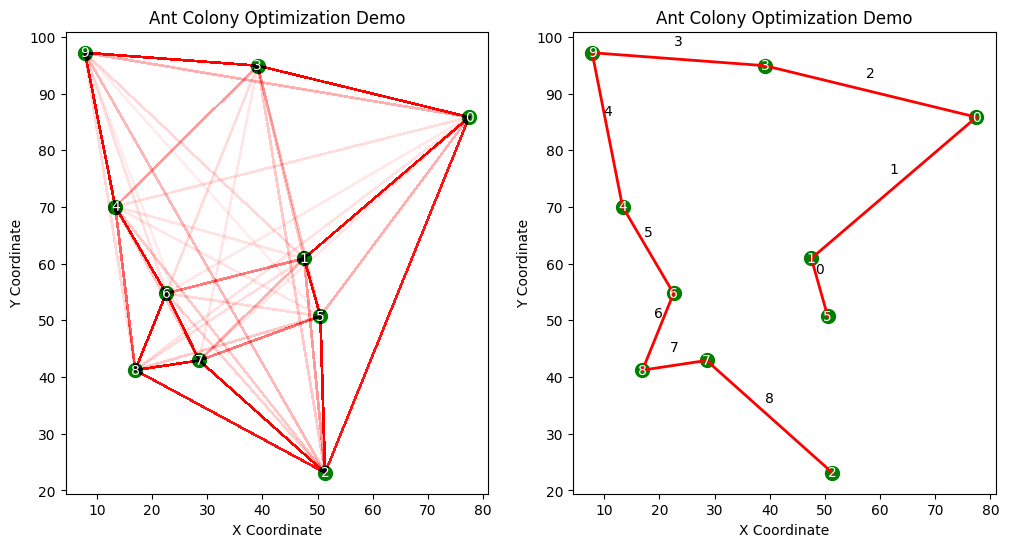

Best path: [5, 1, 0, 3, 9, 4, 6, 8, 7, 2]
Best distance: 250.10100071099075


In [286]:
best_path, best_distance = ant_colony_optimization(num_cities, num_ants, iterations, alpha, beta, decay_factor, Q)
print("Best path:", best_path)
print("Best distance:", best_distance)